## The inviscid Burgers' Equation - A different approach

#### Problem Setup

Setting $u(x,t) = \frac{x}{1+t}$, we'd expect $\nu = 0$ as a parameter.

Then $u_0(x) := u(x,0) = x$.

Using the forward Euler scheme, the equation can be re-written as:

$\frac{u_n - u_{n-1}}{\tau} + u_{n-1} \frac{d}{dx}u_{n-1}  = \nu \frac{d^2}{dx^2}u_{n-1}$

and setting the factor $u_{n-1} = \mu_{n-1}$ (analogously to the previous chapter this is the mean of $u_{n-1}$) to deal with the non-linearity:

$\tau \nu \frac{d^2}{dx^2}u_{n-1} - \tau \mu_{n-1} \frac{d}{dx}u_{n-1} + u_{n-1} = u_{n}$


Consider $u_{n-1}$ to be a Gaussian process.

$u_{n-1} \sim \mathcal{GP}(0, k_{uu}(x_i, x_j; \theta, l))$

And the linear operator:

$\mathcal{L}_x^\nu = \cdot + \tau \nu \frac{d}{dx}\cdot - \tau \mu_{n-1} \frac{d}{dx} \cdot$

so that

$\mathcal{L}_x^\nu u_{n-1} = u_n$

Problem at hand: Estimate $\nu$ (should be $\nu = 0$ in the end).

For the sake of simplicity, take $u := u_{n-1}$ and $f := u_n$.


#### Step 1: Simulate data

Take data points at $t = 0$ for $(u_{n-1})$ and $t = \tau$ for $(u_n)$, where $\tau$ is the time step.

In [68]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
import time

$x \in [0, 1], \; t \in \{0, \tau \}$

In [69]:
tau = 0.001
def get_simulated_data(tau, n=20):
    x = np.random.rand(n)
    y_u = x
    y_f = x/(1+tau)
    return (x, y_u, y_f)

(x, y_u, y_f) = get_simulated_data(tau)

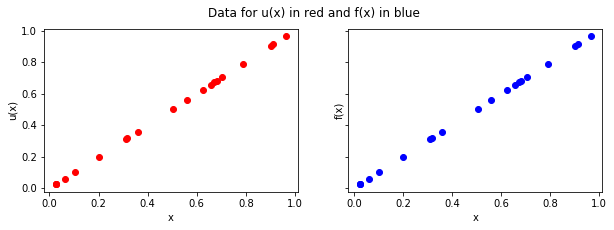

In [70]:
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10,3))
f.suptitle("Data for u(x) in red and f(x) in blue")
ax1.plot(x, y_u, 'ro')
ax1.set(xlabel= r"x", ylabel= "u(x)")
ax2.plot(x, y_f, 'bo')
ax2.set(xlabel= r"x", ylabel= "f(x)");

#### Step 2: Evaluate kernels

1) $k_{uu}(x_i, x_j; \theta, l) = \theta exp(-\frac{1}{2l}(x_i-x_j)^2)$

In [71]:
x_i, x_j, theta, l, nu = sp.symbols('x_i x_j theta l nu')
mu = np.mean(y_u)
kuu_sym = theta*sp.exp(-1/(2*l)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta, l), kuu_sym, "numpy")
def kuu(x, theta, l):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta, l)
    return k

2) $k_{ff}(x_i,x_j;\theta, l,\nu)
= \mathcal{L}_{x_i}^\nu \mathcal{L}_{x_j}^\nu k_{uu}(x_i, x_j; \theta, l) \\
= k_{uu} + \tau \nu \frac{d}{dx_i}k_{uu} - \tau \mu_{n-1} \frac{d}{dx_i}k_{uu} + \tau \nu \frac{d}{dx_j}k_{uu} + \tau^2 \nu^2 \frac{d}{dx_i} \frac{d}{dx_j}k_{uu} - \tau^2 \nu \mu_{n-1}\frac{d^2}{dx_i dx_j} k_{uu} - \tau \mu_{n-1} \frac{d}{dx_j}k_{uu} - \tau^2 \nu \mu_{n-1} \frac{d^2}{dx_i dx_j} k_{uu} + \tau^2 \mu_{n-1}^2 \frac{d^2}{dx_i dx_j}k_{uu}$

In [72]:
kff_sym = kuu_sym \
        + tau*nu*sp.diff(kuu_sym, x_i) \
        - tau*mu*sp.diff(kuu_sym, x_i) \
        + tau*nu*sp.diff(kuu_sym, x_j) \
        + tau**2*nu**2*sp.diff(kuu_sym, x_j, x_i) \
        - tau**2*nu*mu*sp.diff(kuu_sym, x_j, x_i) \
        - tau*mu*sp.diff(kuu_sym, x_j) \
        - tau**2*nu*mu*sp.diff(kuu_sym, x_j, x_i) \
        + tau**2*mu**2*sp.diff(kuu_sym, x_j, x_i)
kff_fn = sp.lambdify((x_i, x_j, theta, l, nu), kff_sym, "numpy")
def kff(x, theta, l, nu):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, l, nu)
    return k

3) $k_{fu}(x_i,x_j;\theta,l,\nu)
= \mathcal{L}_{x_i}^\nu k_{uu}(x_i, x_j; \theta, l) \\
= k_{uu} + \tau \nu \frac{d}{dx_i}k_{uu} - \tau \mu_{n-1}\frac{d}{dx_i}k_{uu}$

In [73]:
kfu_sym = kuu_sym + tau*nu*sp.diff(kuu_sym, x_i) - tau*mu*sp.diff(kuu_sym, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, l, nu), kfu_sym, "numpy")
def kfu(x, theta, l, nu):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kfu_fn(x[i], x[j], theta, l, nu)
    return k

4) $k_{uf}(x_i,x_j;\theta, l, \nu)$ is given by the transpose of $k_{fu}(x_i,x_j;\theta, l, \nu)$.

In [74]:
def kuf(x, theta, l, nu):
    return kfu(x,theta, l, nu).T

#### Steps 3 and 4: Compute NLML and optimize the hyperparameters

In [75]:
def nlml(params, x, y1, y2, s):
    theta_exp = np.exp(params[0]) 
    l_exp = np.exp(params[1])
    K = np.block([
        [kuu(x, theta_exp, l_exp) + s*np.identity(x.size), kuf(x, theta_exp, l_exp, params[2])],
        [kfu(x, theta_exp, l_exp, params[2]), kff(x, theta_exp, l_exp, params[2]) + s*np.identity(x.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [76]:
m = minimize(nlml, np.random.rand(3), args=(x, y_u, y_f, 1e-7), method=\
             "Nelder-Mead", options = {'maxiter' : 1000})

In [77]:
m.x[2]   # This is our inferred value for \nu

0.00021347647791778476

In [79]:
m

 final_simplex: (array([[6.98888116e+00, 8.08598514e+00, 2.13476478e-04],
       [6.98887122e+00, 8.08597556e+00, 2.13481534e-04],
       [6.98882034e+00, 8.08592923e+00, 2.13858738e-04],
       [6.98884831e+00, 8.08595542e+00, 2.13548057e-04]]), array([-291.94040781, -291.94038991, -291.94038888, -291.940384  ]))
           fun: -291.9404078103601
       message: 'Optimization terminated successfully.'
          nfev: 209
           nit: 106
        status: 0
       success: True
             x: array([6.98888116e+00, 8.08598514e+00, 2.13476478e-04])

#### Step 5: Analysis w.r.t. the number of data points (up to 25):

In this section we want to analyze the error of our algorithm and plot its time complexity.

In [13]:
res = np.zeros((5,25))
timing = np.zeros((5,25))
warnings.filterwarnings("ignore")
for k in range(5):
    for n in range(25):
        start_time = time.time()
        (x, y_u, y_f) = get_simulated_data(tau, n)
        m = minimize(nlml, np.random.rand(3), args=(x, y_u, y_f, 1e-7), method="Nelder-Mead")
        res[k][n] = m.x[2]
        timing[k][n] = time.time() - start_time

**Plotting the error in our estimate:**

The error is given by $| \nu_{estimate} - \nu_{true} |$.

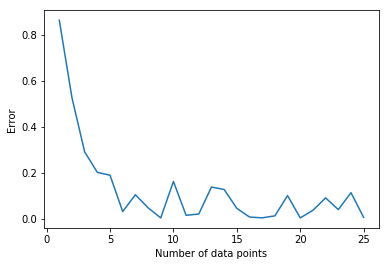

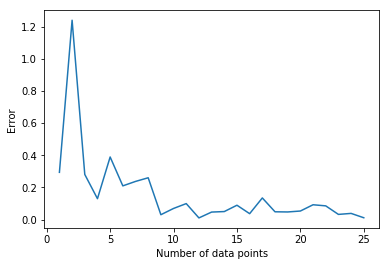

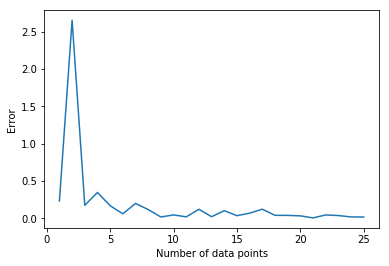

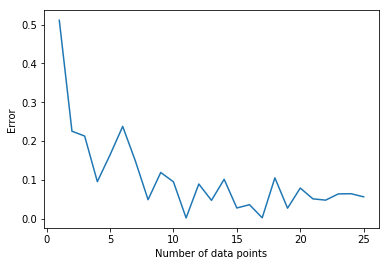

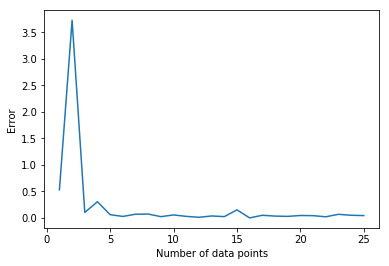

In [20]:
lin = np.linspace(1, res.shape[1], res.shape[1])

for i in range(res.shape[0]):
    plt.plot(lin, np.abs(res[i,:]))
    plt.ylabel('Error')
    plt.xlabel('Number of data points')
    plt.show()

We plot the error with respect to the number of data samples for five runs of the program:

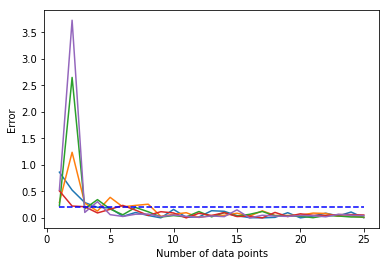

In [67]:
lin = np.linspace(1, res.shape[1], res.shape[1])

for i in range(res.shape[0]):
    plt.plot(lin, np.abs(res[i,:]))
    plt.ylabel('Error')
    plt.xlabel('Number of data points')

est = np.repeat(0.2, len(lin))
plt.plot(lin, est, color='blue', linestyle='dashed')
plt.show()

We see that for n sufficiently large (in this case $n \geq 8$), we can assume the error to be bounded by 0.2.

**Plotting the error between the solution and the approximative solution:**

**Plotting the execution time:**

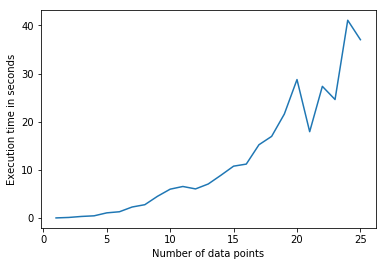

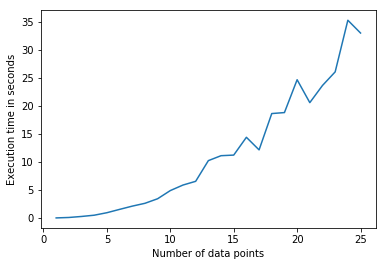

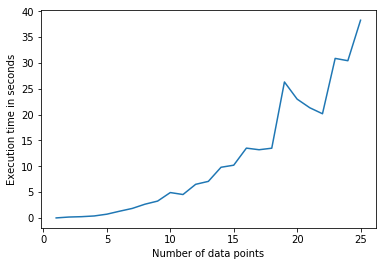

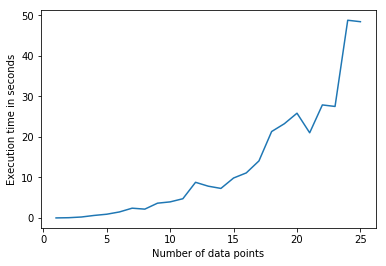

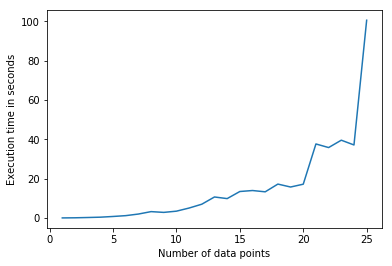

In [17]:
lin = np.linspace(1, timing.shape[1], timing.shape[1])

for i in range(timing.shape[0]):
    plt.plot(lin, timing[i,:])
    plt.ylabel('Execution time in seconds')
    plt.xlabel('Number of data points')
    plt.show()

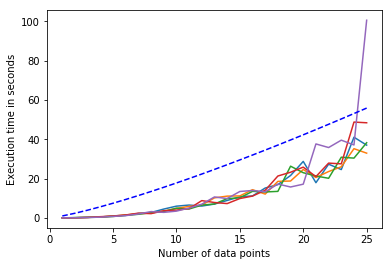

In [18]:
lin = np.linspace(1, timing.shape[1], timing.shape[1])

for i in range(timing.shape[0]):
    plt.plot(lin, timing[i,:])
    plt.ylabel('Execution time in seconds')
    plt.xlabel('Number of data points')

est = lin**(1.25)
plt.plot(lin, est, color='blue', linestyle='dashed')
plt.show()

We again observe a time complexity of roughly $\mathcal{O}(n^{5/4})$ (blue-dashed line). <br>